Plots for the experiments comparing DSCO, C-OCBA, IKG, and
GP-C-OCBA.

Found 300 output files.
Skipping /Users/saitcakmak/contextual_rs/experiments/simulation_experiments/config_covid_v4/IKG/0035_IKG_f_2.pt due to missing samples!
Skipping /Users/saitcakmak/contextual_rs/experiments/simulation_experiments/config_covid_v4/IKG/0046_IKG_f_2.pt due to missing samples!
Skipping /Users/saitcakmak/contextual_rs/experiments/simulation_experiments/config_covid_v4/IKG/0047_IKG_f_2.pt due to missing samples!
Skipping /Users/saitcakmak/contextual_rs/experiments/simulation_experiments/config_covid_v4/IKG/0020_IKG_f_2.pt due to missing samples!
Skipping /Users/saitcakmak/contextual_rs/experiments/simulation_experiments/config_covid_v4/GP-C-OCBA/0048_GP-C-OCBA_f_2.pt due to missing samples!
Skipping /Users/saitcakmak/contextual_rs/experiments/simulation_experiments/config_covid_v4/GP-C-OCBA/0042_GP-C-OCBA_f_2.pt due to missing samples!


/var/folders/g_/w2hgyqw97tl9ncfh6tzv90kr0000gn/T/ipykernel_33494/2620399812.py:183: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x_range = torch.range(expected_total_samples - mean.shape[0] + 1, expected_total_samples)


Plotting [46, 48, 50, 50, 50, 50] outputs!
average wall times [20011.4667640147, 7019.298704683781, 1088.3266173934937, 1064.9473392772675, 998.4161235189438, 1037.7191384744644]
These do NOT include the experiment running time!!


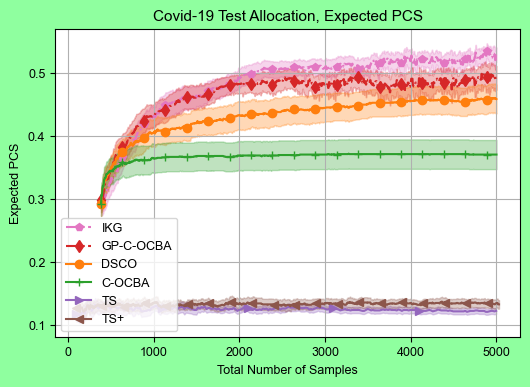

In [3]:
import json
import os

import torch
from torch import Tensor

%matplotlib inline
import matplotlib.pyplot as plt

font_args = {
    "family": "sans-serif",
    "sans-serif": "Arial",
    # "size": 9,
}
# plt.rc("font", **font_args)
# plt.rcParams["font.family"] = "cursive"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 11


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()

# [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2',
# u'#7f7f7f', u'#bcbd22', u'#17becf']
# plot_kwargs = {
#     "IKG": {"ls": "-.", "marker": "p", "color": u'#e377c2'},
#     "GP-C-OCBA": {"ls": "-.", "marker": "d", "color": u'#d62728'},
#     "DSCO": {"marker": "o", "color": u'#ff7f0e'},
#     "C-OCBA": {"marker": "+", "color": u'#2ca02c'},
#     "TS": {"marker": ">", "color": u'#9467bd'},
#     "TS+": {"marker": "<", "color": u'#8c564b'},
# }
plot_kwargs = {
    "IKG_f_2": {"ls": "-.", "marker": "p", "color": u'#e377c2'},
    # "IKG_r_8": {"ls": "-.", "marker": "p", "color": u'#e377c2'},  # use
    "GP-C-OCBA_f_2": {"ls": "-.", "marker": "d", "color": u'#d62728'},
    # "GP-C-OCBA_r_8": {"ls": "-.", "marker": "d", "color": u'#d62728'},
    "DSCO_f_2": {"marker": "o", "color": u'#ff7f0e'},
    "C-OCBA_f_2": {"marker": "+", "color": u'#2ca02c'},
    "TS_e_2": {"marker": ">", "color": u'#9467bd'},
    # "TS_f_2": {"marker": ">", "color": u'#9467bd'},  # use
    "TS+_e_2": {"marker": "<", "color": u'#8c564b'},
    # "TS+_f_2": {"marker": "<", "color": u'#8c564b'},
}
plot_title = "Covid-19 Test Allocation, Expected PCS"

all_keys = list(plot_kwargs.keys())
plot_idcs = None
moving_average_window = 1
plot_errors = False
plot_shaded = True
err_coef = 1.96

def plot_experiment(
    dirname: str, row: int, col: int,
) -> Tensor:
    exp_dir = os.path.join(current_dir, dirname)
    config_path = os.path.join(exp_dir, "config.json")

    with open(config_path, "r") as f:
        config_dict = json.load(f)
        # print(f"Config: \n {json.dumps(config_dict, indent=4)}")
    expected_total_samples = config_dict["num_total_samples"]
    # expected_total_samples = 1500

    # get all the output files
    output_files = []
    for entry in os.scandir(exp_dir):
        if entry.is_dir():
            entry_list = os.scandir(entry.path)
            output_files += [
                file.path for file in entry_list if file.path[-3:] == ".pt"
            ]
    print(f"Found {len(output_files)} output files.")

    # plot final values, averaged over replications.
    # final values is a list of tensors, one tensor per label
    key = "rho_cs"
    sample_count_lists = [list() for _ in all_keys]
    output_lists = [list() for _ in all_keys]
    wall_times = [0.] * len(all_keys)
    time_counts = [0] * len(all_keys)
    for out_path in output_files:
        try:
            out_dict = torch.load(out_path)
        except RuntimeError:
            print(f"Got an error while importing {out_path}!")
            continue
        try:
            label_idx = all_keys.index(out_dict["label"])
        except ValueError:
            continue
        output = out_dict[key].cpu()
        if "TS" not in out_dict["label"] and out_dict["Y"].shape[0] != \
                expected_total_samples:
            print(f"Skipping {out_path} due to missing samples!")
            continue
        output_lists[label_idx].append(output)
        # TODO: May want to modify this at some point.
        wall_times[label_idx] += float(out_dict["wall_time"][-1])
        time_counts[label_idx] += 1
        sample_count_lists[label_idx].append(out_dict.get("samples_count_all", None))

    # calculate the mean and std for plotting
    key_counts = list()
    plot_xs = list()
    plot_means = list()
    plot_stds = list()
    for key_idx, out_list in enumerate(output_lists):
        if "TS" in all_keys[key_idx]:
            # For the TS algorithms.
            # Need to find the X / Y combination based on sample counts
            samples_so_far_list = []
            output_count = len(out_list)
            for j in range(output_count):
                samples_so_far_list.append(
                    sample_count_lists[key_idx][j].sum(dim=-1).sum(dim=-1)
                )
            if len(samples_so_far_list) == 0:
                key_counts.append(0)
                plot_means.append(None)
                continue
            all_sample_counts = torch.cat(samples_so_far_list, dim=0).unique(
                sorted=True
            )
            plot_xs.append(all_sample_counts)
            pcs_mapped = torch.zeros(output_count, all_sample_counts.shape[0])
            for j, out in enumerate(out_list):
                sample_counts = samples_so_far_list[j][1:]
                assert out.shape[0] == sample_counts.shape[0]
                ref_idx, mapped_idx = 0, 0
                while mapped_idx < all_sample_counts.shape[0] - 1:
                    # We want to set the value at the mapped_idx equal to value at ref
                    #   idx as long as ref idx is the largest sample count that is less
                    #   than or equal to the sample count at the mapped idx.
                    # So, if we had all sample counts [4, 5, 6, 7] and the reference
                    #   sample counts as [4, 6] with the corresponding values as [0.5,
                    #   0.6], we want the output to be [0.5, 0.5, 0.6, 0.6].
                    if ref_idx  < sample_counts.shape[0] - 1 and \
                            sample_counts[ref_idx + 1] == all_sample_counts[mapped_idx]:
                        ref_idx += 1
                    pcs_mapped[j][mapped_idx] = out[ref_idx]
                    mapped_idx += 1
            if moving_average_window > 1:
                raise NotImplementedError
            plot_means.append(pcs_mapped.mean(dim=0))
            if plot_means[-1][-1] == 0:
                plot_means[-1][-1] = plot_means[-1][-2]
            plot_stds.append(pcs_mapped.std(dim=0) / (float(len(pcs_mapped)) ** 0.5))
            key_counts.append(pcs_mapped.shape[0])

        else:
            # This handles the non-TS algorithm's outputs.
            try:
                out_tensor = torch.stack(out_list)
                key_counts.append(out_tensor.shape[0])
                mean = out_tensor.mean(dim=0)
                std = out_tensor.std(dim=0) / (float(len(out_tensor)) ** 0.5)
                if moving_average_window > 1:
                    tmp_mean = torch.zeros_like(mean)
                    tmp_std = torch.zeros_like(std)
                    for i in range(tmp_mean.shape[0]):
                        l_ind = max(0, i - moving_average_window)
                        tmp_mean[i] = torch.mean(mean[l_ind: i+1])
                        tmp_std[i] = torch.mean(std[l_ind: i+1])
                    mean = tmp_mean
                    std = tmp_std
                plot_means.append(mean)
                plot_stds.append(std)
                x_range = torch.range(expected_total_samples - mean.shape[0] + 1, expected_total_samples)
                plot_xs.append(x_range)
            except:
                key_counts.append(0)
                plot_xs.append(None)
                plot_means.append(None)
                plot_stds.append(None)

    print(f"Plotting {key_counts} outputs!")

    for i in range(len(all_keys)):
        if wall_times[i]:
            wall_times[i] /= time_counts[i]

    print(f"average wall times {wall_times}")
    print("These do NOT include the experiment running time!!")

    # plot
    ax = axes[row, col]

    plot_idcs = range(len(key_counts))

    for i in plot_idcs:
        if plot_means[i] is None:
            continue
        if "covid" in config_path:
            plot_means[i] /= 27.0
            plot_stds[i] /= 27.0

        if plot_errors:
            ax.errorbar(
                x=plot_xs[i],
                y=plot_means[i],
                yerr=plot_stds[i],
                errorevery=marker_frequency,
                label=all_keys[i][:-4],
                markevery=marker_frequency,
                **plot_kwargs[all_keys[i]]

            ) 
        else:
            y = plot_means[i][::5]
            x=plot_xs[i][::5]
            ax.plot(
                x, 
                y,
                label=all_keys[i][:-4],
                markevery=marker_frequency,
                **plot_kwargs[all_keys[i]]
            )
        if plot_shaded:
            yerr=err_coef*plot_stds[i][::5]
            ax.fill_between(
                x,
                y-yerr,
                y+yerr,
                alpha=0.3,
                color=plot_kwargs[all_keys[i]]["color"],
            )
    ax.grid()
    ax.legend(loc=3, prop={'size': MEDIUM_SIZE})
    ax.set_title(plot_title, fontdict={"fontsize": BIGGER_SIZE})
    return output_lists

marker_frequency = 50

figsize = (6, 4)
# figsize = (20, 16)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex="all", figsize=figsize, squeeze=False)

_ = plot_experiment("config_covid_v4", row=0, col=0)
axes[0, 0].set_xlabel("Total Number of Samples")
axes[0, 0].set_ylabel("Expected PCS")

# fig.tight_layout()
plt.savefig(os.path.join("plots", "covid_iters.pdf"), dpi=300)
fig.patch.set_facecolor('xkcd:mint green')
plt.show()